C:\Users\김효준\AppData\Local\Temp\ipykernel_16256\3650635250.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_df[time_columns] = ride_df[time_columns].apply(pd.to_numeric, errors='coerce')
C:\Users\김효준\AppData\Local\Temp\ipykernel_16256\3650635250.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_df[time_columns] = exit_df[time_columns].apply(pd.to_numeric, errors='coerce')
C:\Users\김효준\AppData\Local\Temp\ipykernel_16256\3650635250.py:54: SettingWithCopyWarning: 
A value is trying to be set o

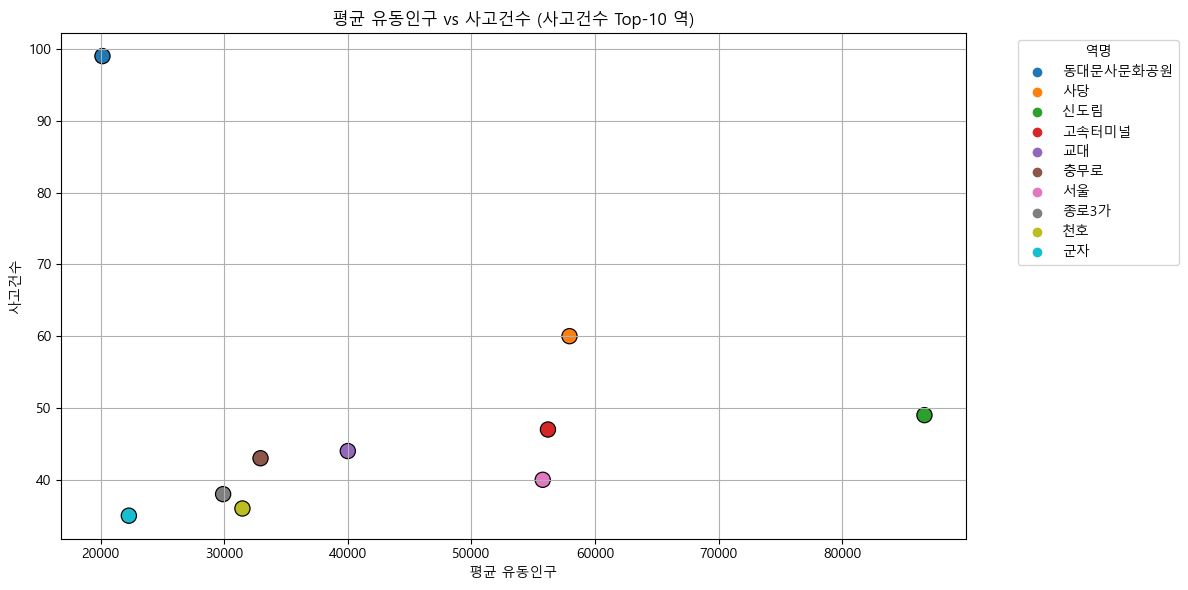

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False


# 1. 정규화 함수
def normalize_station(name: str) -> str:
    name = str(name)
    name = re.sub(r'\(.*?\)', '', name)
    return name.replace('역', '').strip()

# 2. 연도별 시간대별 데이터 경로
yearly_files = {
    2020: "서울교통공사_역별 시간대별 승하차인원(20.1~20.12).csv",
    2021: "서울교통공사_역별 시간대별 승하차인원(21.1~21.12).csv",
    2022: "서울교통공사_역별 시간대별 승하차인원(22.1~22.12).csv",
    2023: "서울교통공사_역별 시간대별 승하차인원(23.1~23.12).csv",
    2024: "서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv"
}

# 3. 유동인구 계산
station_daily_list = []

for year, path in yearly_files.items():
    df = pd.read_csv(path, encoding='cp949')

    date_col = [col for col in df.columns if '날짜' in col or '일자' in col or '일' in col][0]
    a_col = [col for col in df.columns if '구분' in col][0]

    ride_df = df[df[a_col] == '승차']
    exit_df = df[df[a_col] == '하차']

    if year == 2020:
        time_columns = [col for col in df.columns if '~' in col and '이전' not in col and '이후' not in col]
    else:
        time_columns = [col for col in df.columns if '시' in col and '-' in col]

    ride_df[time_columns] = ride_df[time_columns].apply(pd.to_numeric, errors='coerce')
    exit_df[time_columns] = exit_df[time_columns].apply(pd.to_numeric, errors='coerce')

    ride_df['총승차'] = ride_df[time_columns].sum(axis=1)
    exit_df['총하차'] = exit_df[time_columns].sum(axis=1)

    total_df = pd.merge(
        ride_df[[date_col, '역명', '총승차']],
        exit_df[[date_col, '역명', '총하차']],
        on=[date_col, '역명'],
        how='outer'
    )

    total_df['총이용객'] = total_df[['총승차', '총하차']].sum(axis=1)
    total_df['정규역명'] = total_df['역명'].apply(normalize_station)
    total_df['날짜'] = pd.to_datetime(total_df[date_col], errors='coerce')

    station_daily_list.append(total_df[['정규역명', '날짜', '총이용객']])

# 4. 전체 기간 유동인구 평균 계산
station_daily_all = pd.concat(station_daily_list, ignore_index=True)
avg_pop = (
    station_daily_all
    .groupby('정규역명')['총이용객']
    .mean()
    .reset_index(name='평균유동인구')
)

# 5. 사고 데이터 불러오기
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding='cp949')
accident_df['정규역명'] = accident_df['발생역'].apply(normalize_station)

accident_counts = (
    accident_df['정규역명']
    .value_counts()
    .reset_index(name='사고건수')
    .rename(columns={'index': '정규역명'})
)

# 6. 병합 및 Top-10 추출
metrics = (
    accident_counts
    .merge(avg_pop, on='정규역명', how='left')
    .dropna()
    .sort_values('사고건수', ascending=False)
    .reset_index(drop=True)
)

top10 = metrics.head(10)

# 7. 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=top10,
    x='평균유동인구',
    y='사고건수',
    hue='정규역명',
    palette='tab10',
    s=120,
    edgecolor='k'
)
plt.title('평균 유동인구 vs 사고건수 (사고건수 Top-10 역)')
plt.xlabel('평균 유동인구')
plt.ylabel('사고건수')
plt.legend(title='역명', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


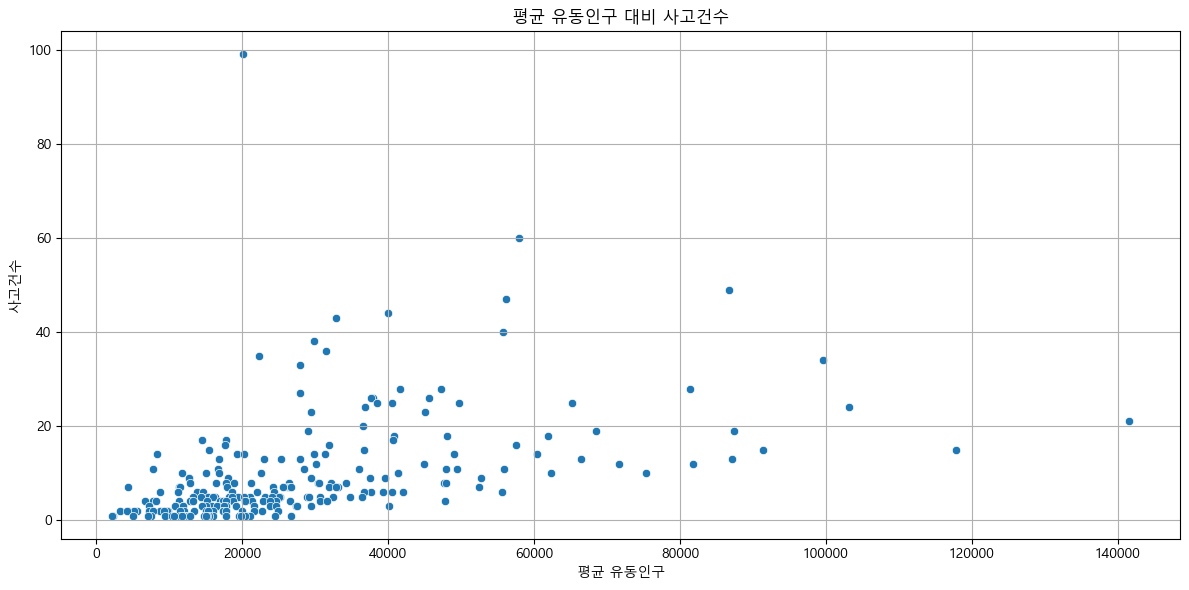

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform



# 전체 산점도 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(data=metrics, x='평균유동인구', y='사고건수')
plt.title('평균 유동인구 대비 사고건수')
plt.xlabel('평균 유동인구')
plt.ylabel('사고건수')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:



all_data = []

for year, path in yearly_files.items():
    df = pd.read_csv(path, encoding='cp949')
    date_col = [col for col in df.columns if '날짜' in col or '일자' in col or '일' in col][0]
    a_col = [col for col in df.columns if '구분' in col][0]

    ride_df = df[df[a_col] == '승차'].copy()
    exit_df = df[df[a_col] == '하차'].copy()

    if year == 2020:
        time_columns = [col for col in df.columns if '~' in col and '이전' not in col and '이후' not in col]
    else:
        time_columns = [col for col in df.columns if '시' in col and '-' in col]

    ride_df.loc[:, time_columns] = ride_df[time_columns].apply(pd.to_numeric, errors='coerce')
    exit_df.loc[:, time_columns] = exit_df[time_columns].apply(pd.to_numeric, errors='coerce')

    ride_df.loc[:, '총승차'] = ride_df[time_columns].sum(axis=1)
    exit_df.loc[:, '총하차'] = exit_df[time_columns].sum(axis=1)

    total_df = pd.merge(
        ride_df[[date_col, '역명', '총승차']],
        exit_df[[date_col, '역명', '총하차']],
        on=[date_col, '역명'],
        how='outer'
    )

    total_df['총이용객'] = total_df[['총승차', '총하차']].sum(axis=1)
    total_df['날짜'] = pd.to_datetime(total_df[date_col], errors='coerce')

    all_data.append(total_df[['날짜', '총이용객']])

# 전체 병합
all_daily = pd.concat(all_data, ignore_index=True)

# 평균 계산
overall_days = all_daily['날짜'].nunique()
overall_sum = all_daily['총이용객'].sum()
overall_avg = int(overall_sum / overall_days)

# 결과 출력
print(f"기간(2020-1 ~ 2024-12) 일 평균 이용객 수 : {overall_avg:,} 명")


C:\Users\김효준\AppData\Local\Temp\ipykernel_15256\1507685870.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='cp949')


기간(2020-1 ~ 2024-12) 일 평균 이용객 수 : 9,698,545 명
